Possible labels: {0, 1}
num SVs: 83


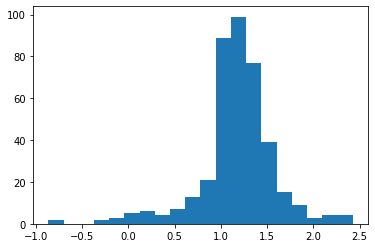

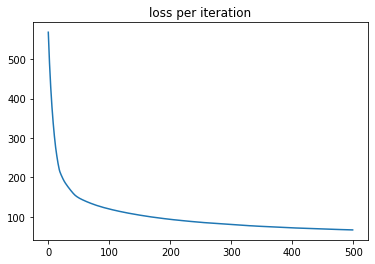

train duration: 0:00:00.556178
train score: 0.9800995024875622 duration: 0:00:00.016420
test score: 0.9595959595959596 duration: 0:00:00.007244


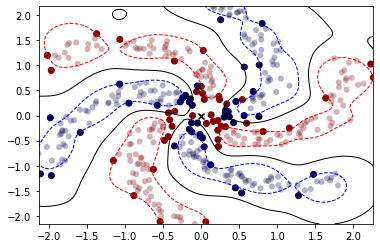

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Aug 2 00:51:21 2020

@author: Priyanshu Kumawat
"""
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from datetime import datetime


import numpy as np
import matplotlib.pyplot as plt

#make generic datasets for understanding

#spiral data generate
def get_spiral():
  # Idea: radius -> low...high
  #           (don't start at 0, otherwise points will be "mushed" at origin)
  #       angle = low...high proportional to radius
  #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
  # x = rcos(theta), y = rsin(theta) as usual

  radius = np.linspace(1, 10, 100)
  thetas = np.empty((6, 100))
  for i in range(6):
    start_angle = np.pi*i / 3.0
    end_angle = start_angle + np.pi / 2
    points = np.linspace(start_angle, end_angle, 100)
    thetas[i] = points

  # convert into cartesian coordinates
  x1 = np.empty((6, 100))
  x2 = np.empty((6, 100))
  for i in range(6):
    x1[i] = radius * np.cos(thetas[i])
    x2[i] = radius * np.sin(thetas[i])

  # inputs
  X = np.empty((600, 2))
  X[:,0] = x1.flatten()
  X[:,1] = x2.flatten()

  # add noise
  X += np.random.randn(600, 2)*0.5

  # targets
  Y = np.array([0]*100 + [1]*100 + [0]*100 + [1]*100 + [0]*100 + [1]*100)
  return X, Y


# cloud data set generate
def get_clouds():
  N = 1000
  c1 = np.array([2, 2])
  c2 = np.array([-2, -2])
  # c1 = np.array([0, 3])
  # c2 = np.array([0, 0])
  X1 = np.random.randn(N, 2) + c1
  X2 = np.random.randn(N, 2) + c2
  X = np.vstack((X1, X2))
  Y = np.array([-1]*N + [1]*N)
  return X, Y
 
 #donut data generation    
def get_donut():
  N = 200
  R_inner = 5
  R_outer = 10

  # distance from origin is radius + random normal
  # angle theta is uniformly distributed between (0, 2pi)
  R1 = np.random.randn(N//2) + R_inner
  theta = 2*np.pi*np.random.random(N//2)
  X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

  R2 = np.random.randn(N//2) + R_outer
  theta = 2*np.pi*np.random.random(N//2)
  X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

  X = np.concatenate([ X_inner, X_outer ])
  Y = np.array([0]*(N//2) + [1]*(N//2))
  return X, Y

#2d xor generic data 
def get_xor():
  X = np.zeros((200, 2))
  X[:50] = np.random.random((50, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
  X[50:100] = np.random.random((50, 2)) / 2 # (0-0.5, 0-0.5)
  X[100:150] = np.random.random((50, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
  X[150:] = np.random.random((50, 2)) / 2 + np.array([[0.5, 0]]) # (0.5-1, 0-0.5)
  Y = np.array([0]*100 + [1]*100)
  return X, Y




# kernels
def linear(X1, X2, c=0):
  return X1.dot(X2.T) + c

def rbf(X1, X2, gamma=None):
  if gamma is None:
    gamma = 1.0 / X1.shape[-1] # 1 / D
  # gamma = 0.05
  # gamma = 5. # for donut and spiral
  if np.ndim(X1) == 1 and np.ndim(X2) == 1:
    result = np.exp(-gamma * np.linalg.norm(X1 - X2)**2)
  elif (np.ndim(X1) > 1 and np.ndim(X2) == 1) or (np.ndim(X1) == 1 and np.ndim(X2) > 1):
    result = np.exp(-gamma * np.linalg.norm(X1 - X2, axis=1)**2)
  elif np.ndim(X1) > 1 and np.ndim(X2) > 1:
    result = np.exp(-gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2)
  return result

def sigmoid(X1, X2, gamma=0.05, c=1):
  return np.tanh(gamma * X1.dot(X2.T) + c)


class KernelSVM:
  def __init__(self, kernel=linear, C=1.0):
    self.C = C
    self.kernel = kernel

  def _objective(self, margins):
    return 0.5 * self.u.dot(self.K.dot(self.u)) + \
      self.C * np.maximum(0, 1 - margins).sum()

  def fit(self, X, Y, lr=1e-5, n_iters=400):
    N, D = X.shape
    self.N = N
    self.u = np.random.randn(N)
    self.b = 0

    # setup kernel matrix
    self.X = X
    self.Y = Y
    self.K = self.kernel(X, X)

    # gradient descent
    losses = []
    for _ in range(n_iters):
      margins = Y * (self.u.dot(self.K) + self.b)
      loss = self._objective(margins)
      losses.append(loss)
      
      idx = np.where(margins < 1)[0]
      grad_u = self.K.dot(self.u) - self.C * Y[idx].dot(self.K[idx])
      self.u -= lr * grad_u
      grad_b = -self.C * Y[idx].sum()
      self.b -= lr * grad_b

    self.support_ = np.where((Y * (self.u.dot(self.K) + self.b)) <= 1)[0]
    print("num SVs:", len(self.support_))

    # print("w:", self.w)
    # print("b:", self.b)

    # hist of margins
    m = Y * (self.u.dot(self.K) + self.b)
    plt.hist(m, bins=20)
    plt.show()

    plt.plot(losses)
    plt.title("loss per iteration")
    plt.show()

  def _decision_function(self, X):
    return self.u.dot(self.kernel(self.X, X)) + self.b

  def predict(self, X):
    return np.sign(self._decision_function(X))

  def score(self, X, Y):
    P = self.predict(X)
    return np.mean(Y == P)


def plot_decision_boundary(model, X, Y, resolution=100, colors=('b', 'k', 'r')):
  np.warnings.filterwarnings('ignore')
  fig, ax = plt.subplots()

  # Generate coordinate grid of shape [resolution x resolution]
  # and evaluate the model over the entire space
  x_range = np.linspace(X[:,0].min(), X[:,0].max(), resolution)
  y_range = np.linspace(X[:,1].min(), X[:,1].max(), resolution)
  grid = [[model._decision_function(np.array([[xr, yr]])) for yr in y_range] for xr in x_range]
  grid = np.array(grid).reshape(len(x_range), len(y_range))
  
  # Plot decision contours using grid and
  # make a scatter plot of training data
  ax.contour(x_range, y_range, grid.T, (-1, 0, 1), linewidths=(1, 1, 1),
             linestyles=('--', '-', '--'), colors=colors)
  ax.scatter(X[:,0], X[:,1],
             c=Y, lw=0, alpha=0.3, cmap='seismic')
  
  # Plot support vectors (non-zero alphas)
  # as circled points (linewidth > 0)
  mask = model.support_
  ax.scatter(X[:,0][mask], X[:,1][mask],
             c=Y[mask], cmap='seismic')

  # debug
  ax.scatter([0], [0], c='black', marker='x')

  # debug
  # x_axis = np.linspace(X[:,0].min(), X[:,0].max(), 100)
  # w = model.w
  # b = model.b
  # # w[0]*x + w[1]*y + b = 0
  # y_axis = -(w[0]*x_axis + b)/w[1]
  # plt.plot(x_axis, y_axis, color='purple')
  # margin_p = (1 - w[0]*x_axis - b)/w[1]
  # plt.plot(x_axis, margin_p, color='orange')
  # margin_n = -(1 + w[0]*x_axis + b)/w[1]
  # plt.plot(x_axis, margin_n, color='orange')

  plt.show()


def clouds():
  X, Y = get_clouds()
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)
  return Xtrain, Xtest, Ytrain, Ytest, linear, 1e-5, 500


def medical():
  data = load_breast_cancer()
  X, Y = data.data, data.target
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)
  return Xtrain, Xtest, Ytrain, Ytest, linear, 1e-3, 200

def xor():
  X, Y = get_xor()
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)
  kernel = lambda X1, X2: rbf(X1, X2, gamma=3.)
  return Xtrain, Xtest, Ytrain, Ytest, kernel, 1e-3, 500

def donut():
  X, Y = get_donut()
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)
  kernel = lambda X1, X2: rbf(X1, X2, gamma=1.)
  return Xtrain, Xtest, Ytrain, Ytest, kernel, 1e-3, 300

def spiral():
  X, Y = get_spiral()
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)
  kernel = lambda X1, X2: rbf(X1, X2, gamma=5.)
  return Xtrain, Xtest, Ytrain, Ytest, kernel, 1e-3, 500

if __name__ == '__main__':
  Xtrain, Xtest, Ytrain, Ytest, kernel, lr, n_iters = spiral()
  print("Possible labels:", set(Ytrain))

  # make sure the targets are (-1, +1)
  Ytrain[Ytrain == 0] = -1
  Ytest[Ytest == 0] = -1

  # scale the data
  scaler = StandardScaler()
  Xtrain = scaler.fit_transform(Xtrain)
  Xtest = scaler.transform(Xtest)

  # now we'll use our custom implementation
  model = KernelSVM(kernel=kernel, C=1.0)

  t0 = datetime.now()
  model.fit(Xtrain, Ytrain, lr=lr, n_iters=n_iters)
  print("train duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("train score:", model.score(Xtrain, Ytrain), "duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("test score:", model.score(Xtest, Ytest), "duration:", datetime.now() - t0)

  if Xtrain.shape[1] == 2:
    plot_decision_boundary(model, Xtrain, Ytrain)



For Donut data


Possible labels: {0, 1}
num SVs: 32


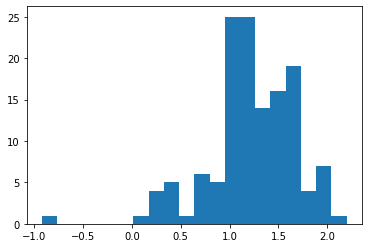

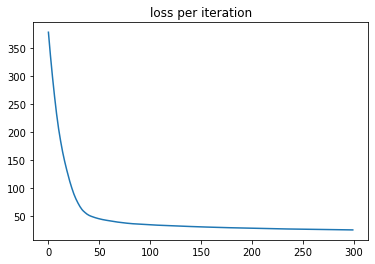

train duration: 0:00:00.387187
train score: 0.9925373134328358 duration: 0:00:00.005239
test score: 0.9848484848484849 duration: 0:00:00.002758


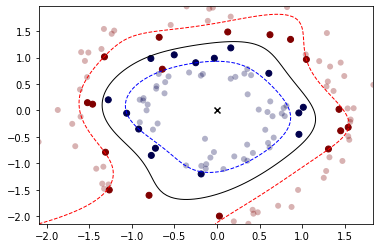

In [9]:
  Xtrain, Xtest, Ytrain, Ytest, kernel, lr, n_iters = donut()
  print("Possible labels:", set(Ytrain))

  # make sure the targets are (-1, +1)
  Ytrain[Ytrain == 0] = -1
  Ytest[Ytest == 0] = -1

  # scale the data
  scaler = StandardScaler()
  Xtrain = scaler.fit_transform(Xtrain)
  Xtest = scaler.transform(Xtest)

  # now we'll use our custom implementation
  model = KernelSVM(kernel=kernel, C=1.0)

  t0 = datetime.now()
  model.fit(Xtrain, Ytrain, lr=lr, n_iters=n_iters)
  print("train duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("train score:", model.score(Xtrain, Ytrain), "duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("test score:", model.score(Xtest, Ytest), "duration:", datetime.now() - t0)

  if Xtrain.shape[1] == 2:
    plot_decision_boundary(model, Xtrain, Ytrain)


For Medical data set i.e is breast cancer dataset

Possible labels: {0, 1}
num SVs: 342


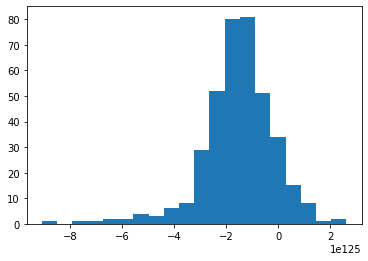

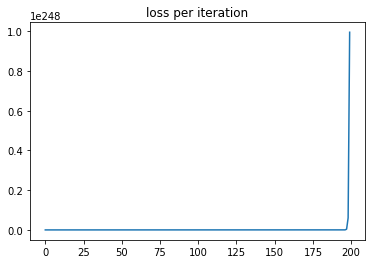

train duration: 0:00:00.544266
train score: 0.10236220472440945 duration: 0:00:00.006403
test score: 0.05319148936170213 duration: 0:00:00.002072


In [11]:
  Xtrain, Xtest, Ytrain, Ytest, kernel, lr, n_iters = medical()
  print("Possible labels:", set(Ytrain))

  # make sure the targets are (-1, +1)
  Ytrain[Ytrain == 0] = -1
  Ytest[Ytest == 0] = -1

  # scale the data
  scaler = StandardScaler()
  Xtrain = scaler.fit_transform(Xtrain)
  Xtest = scaler.transform(Xtest)

  # now we'll use our custom implementation
  model = KernelSVM(kernel=kernel, C=1.0)

  t0 = datetime.now()
  model.fit(Xtrain, Ytrain, lr=lr, n_iters=n_iters)
  print("train duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("train score:", model.score(Xtrain, Ytrain), "duration:", datetime.now() - t0)
  t0 = datetime.now()
  print("test score:", model.score(Xtest, Ytest), "duration:", datetime.now() - t0)

  if Xtrain.shape[1] == 2:
    plot_decision_boundary(model, Xtrain, Ytrain)


**Result:** Our model perform well on both generic and medical data set which shows better result than linear  SVM as expectected 